In [2]:
%load_ext autoreload

In [7]:
import os
import sys
from typing import Tuple, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
import torchvision.transforms as T
import torchvision
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision.models import resnet50
from torch.utils.data import ConcatDataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

sys.path.append('..')

In [8]:
%autoreload 2
from fundus_extractor.utils.general import imshow, normalize_image
from OCT_Feature_Extractor.fundus_extractor.simclr import train_simclr

# Setup

In [9]:
dataset_dir = '/home/ludwig-graef/Workplace/Master_Thesis/Datasets/Fundus_01/data'

In [10]:
dataset_right = ImageFolder(os.path.join(dataset_dir, 'right'), loader=torchvision.io.read_image)
dataset_left = DatasetFolder(os.path.join(dataset_dir, 'left'), torchvision.io.read_image, extensions='.jpeg')
dataset = ConcatDataset([dataset_right, dataset_left])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [12]:
model = resnet50(pretrained=True).to(device)

# Remove the last layer and freeze the weights
model = nn.Sequential(*list(model.children())[:-1])
for param in model.parameters():
    param.requires_grad = False

dataloader = DataLoader(dataset, batch_size=16)

/home/ludwig-graef/Workplace/Programs/miniconda3/envs/m_t/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ludwig-graef/Workplace/Programs/miniconda3/envs/m_t/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Evaluation - Baseline

In [10]:
embeddings_complete, labels_complete = [], []
for images, labels in dataloader:
    with torch.no_grad():
        embeddings = model(normalize_image(images.to(device))).squeeze()
    embeddings_complete.extend(embeddings)
    labels_complete.extend(labels)

In [11]:
embeddings_tensor = torch.stack(embeddings_complete).to(device)
labels_tensor = torch.stack(labels_complete).to(device)

In [12]:
def train_linear_model(embeddings: torch.Tensor, labels: torch.Tensor, device) -> nn.Module:
    # Train a linear model
    linear_model = nn.Linear(embeddings.shape[1], len(torch.unique(labels))).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(linear_model.parameters(), lr=3e-4)

    # Training loop
    for epoch in range(5000):
        optimizer.zero_grad()
        outputs = linear_model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    return linear_model

def plot_roc_curve(labels: List[int], scores: List[float]):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

/tmp/ipykernel_5348/31095354.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = nn.functional.softmax(linear_model(embeddings_tensor)).detach().cpu().numpy()


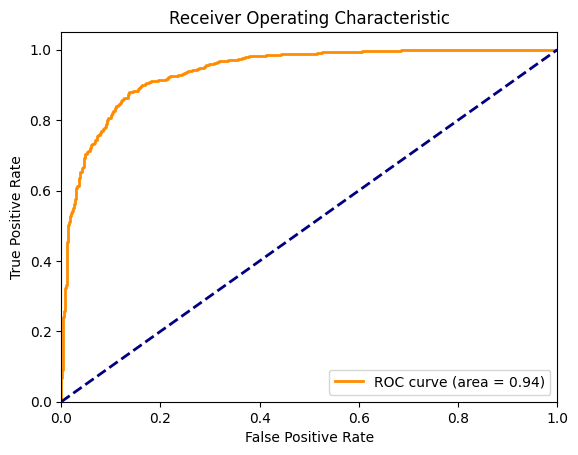

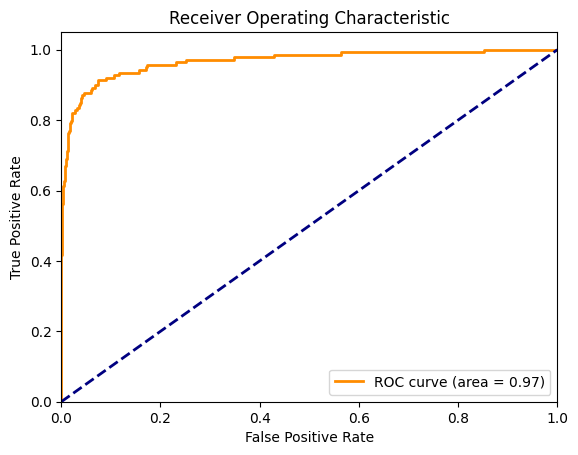

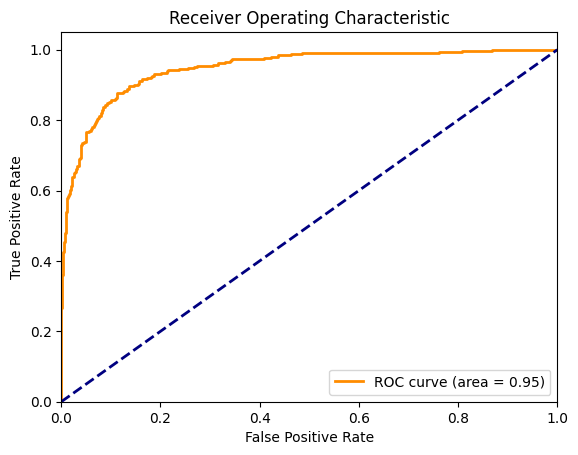

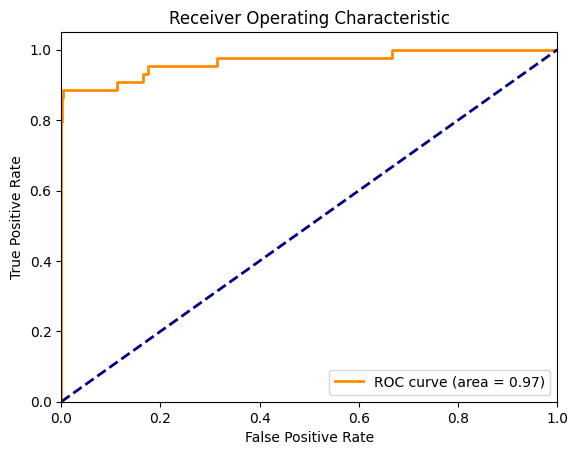

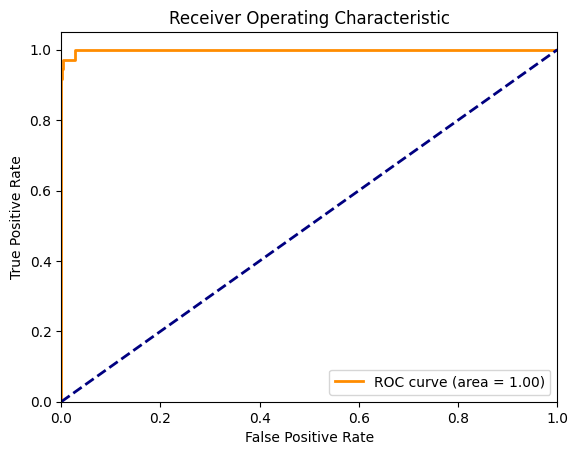

In [13]:
# Train a linear model
linear_model = train_linear_model(embeddings_tensor, labels_tensor, device)

# Calculate scores using the linear model
scores = nn.functional.softmax(linear_model(embeddings_tensor)).detach().cpu().numpy()
# Plot ROC curve for each class
for class_label in torch.unique(labels_tensor):
    class_scores = scores[:, class_label]
    class_labels = [1 if label == class_label else 0 for label in labels_tensor]
    plot_roc_curve(class_labels, class_scores)

# Training - SimCLR